# Spectrometer Controller
OceanInsight Redtide - USB2000 (https://www.oceanoptics.com/resources/legacy-spectrometers/)

Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load Spectrometer
- Be sure to run "seabreeze_os_setup" in the terminal inside the conda environment after installing seabreeze
- If you are on wsl, you will have to bind the usb to wsl. This will only work on Windows 11 on WSL2. Linux or Mac highly recommended 

In [3]:
import seabreeze
from seabreeze.spectrometers import Spectrometer, list_devices
devices = list_devices()
print(devices)
spec = Spectrometer.from_first_available()

[]


SeaBreezeError: No unopened device found.

Take a spectra

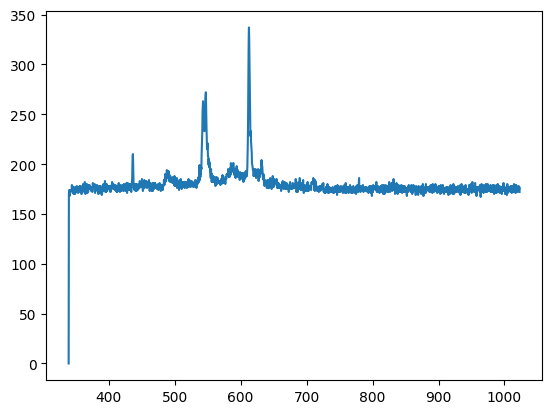

In [6]:
# Set integration time
spec.integration_time_micros(100000)  # 0.1 seconds

# Get wavelengths
wavelengths = spec.wavelengths()

# Get intensities
intensities = spec.intensities()

data = {'Wavelength':wavelengths, 'Intensity':intensities}
spectra = pd.DataFrame(data)
plt.plot(spectra['Wavelength'], spectra['Intensity'])
